In [ ]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf

!pip install pandas_ta
import pandas_ta
import warnings
warnings.filterwarnings('ignore')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=c0b44e90f61191e531da514087743165b682d6f0e499671f58ae92bd04d02eed
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


#1. Download Data

In [ ]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-09-27'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names  =['date', 'ticker']
df.columns = df.columns.str.lower()

[*********************100%%**********************]  503 of 503 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 1443499200, endDate = 1695787200")


#2. Calculate features and technical indicators for each stock

- Garman-Klass Volatility
- RSI: Relative Strength Index measures the speed and magnitude of recent price changes => Momentum indicator
- Bollinger Bands
- ATR: Average True Range measures the average price variation of an asset within a given time frame => Market Volatility
-MACD: Moving Average Convergence Divergence measures market trands and anticipate potential buying or selling signals
- Dollar Volume

In [ ]:

df['garman_klass_vol'] = ((np.log(df['high'] - np.log(df['low']))) ** 2) / 2 - (2*np.log(2) - 1) * (2 * np.log(2) - 1) * ((np.log(df['adj close']) - np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 0])

df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 1])

df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 2])



In [ ]:
def compute_atr(stock_data):
  atr = pandas_ta.atr(high=stock_data['high'],
                      low=stock_data['low'],
                      close=stock_data['close'],
                      length=14)
  return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
  macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
  return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close'] * df['volume'])/1e6

#3. Aggreagte to monthly level and filter top 150 most liquid stocks for each month
- To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [ ]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
            df.unstack('ticker')[last_cols].resample('M').last().stack('ticker')],
          axis=1).dropna()

In [ ]:

data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)


In [ ]:
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2016-10-31 AAL      39.134331  0.402199  3.706314  3.604673  3.655493   
           AAPL     26.248030 -1.038688  3.353305  3.295542  3.324423   
           ABBV     40.620979 -0.893132  3.870876  3.762525  3.816700   
           ABT      34.463528 -1.035224  3.660400  3.559438  3.609919   
           ACN     103.970657 -0.996806  4.664445  4.641169  4.652807   
...                       ...       ...       ...       ...       ...   
2023-09-30 WMT      53.966232 -0.196381  4.026648  3.991704  4.009176   
           XOM     114.292953  0.601335  4.775304  4.695106  4.735205   
           MRNA     98.120003 -0.529511  4.788149  4.582514  4.685332   
           UBER     44.270000 -0.746098  3.917801  3.806654  3.862227   
           ABNB    132.279999 -1.006939  5.024801  4.857047  4.940924   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2016-10-31 AAL             6.530845  1.131595  62.203546  
           AAPL            5.207198 -0.195978  49.891105  
           ABBV            7.885286 -0.760592  27.477829  
           ABT             6.405223 -0.650889  38.008792  
           ACN            11.122462 -0.135456  53.823700  
...                             ...       ...        ...  
2023-09-30 WMT             7.692654  0.399458  54.722509  
           XOM            11.131335  1.400623  59.440179  
           MRNA           10.370675 -0.376899  38.747314  
           UBER            6.949701 -0.133973  45.005268  
           ABNB           11.811278 -0.037854  44.494127  

[12516 rows x 8 columns]

#4. Calculate Monthly Returns for different time horizons as features
- To capture time series dynamics that reflect, for example momentum patterns we compute historical returns using method pct_change(lag), that is, returns over various monthly periods as identified by lags

In [ ]:
def calculate_returns(df):
  outlier_cutoff = 0.005

  lags = [1, 2, 3, 6, 9, 12]

  for lag in lags:
    df[f'return_{lag}m'] = df['adj close']\
                          .pct_change(lag)\
                          .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                upper=x.quantile(1-outlier_cutoff)))\
                          .add(1)\
                          .pow(1/lag)\
                          .sub(1)
  return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()


In [ ]:
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-10-31 AAL      45.534168  1.011062  3.994389  3.849110  3.921750   
           AAPL     39.767765 -0.906642  3.689797  3.596048  3.642922   
           ABBV     68.121460  0.375557  4.298592  4.205859  4.252226   
           ABT      48.733871 -1.040044  3.944558  3.897414  3.920986   
           ACN     129.900726 -0.986514  4.885869  4.806508  4.846188   
...                       ...       ...       ...       ...       ...   
2023-09-30 WMT      53.966232 -0.196381  4.026648  3.991704  4.009176   
           XOM     114.292953  0.601335  4.775304  4.695106  4.735205   
           MRNA     98.120003 -0.529511  4.788149  4.582514  4.685332   
           UBER     44.270000 -0.746098  3.917801  3.806654  3.862227   
           ABNB    132.279999 -1.006939  5.024801  4.857047  4.940924   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2017-10-31 AAL             7.138676 -0.018697  41.051780  -0.014108   
           AAPL            6.680366 -0.039275  69.196661   0.096808   
           ABBV            9.976159  0.473814  55.247906   0.022728   
           ABT             7.693001  0.276132  53.844865   0.021275   
           ACN            12.149380  0.352340  69.365158   0.064180   
...                             ...       ...        ...        ...   
2023-09-30 WMT             7.692654  0.399458  54.722509  -0.000677   
           XOM            11.131335  1.400623  59.440179   0.046947   
           MRNA           10.370675 -0.376899  38.747314  -0.132219   
           UBER            6.949701 -0.133973  45.005268  -0.062672   
           ABNB           11.811278 -0.037854  44.494127   0.005549   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-10-31 AAL      0.022981  -0.023860   0.016495   0.007008    0.012702  
           AAPL     0.015250   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048454   0.037202   0.028692   0.027398    0.018728  
...                      ...        ...        ...        ...         ...  
2023-09-30 WMT      0.010014   0.012354   0.017574   0.016553    0.020256  
           XOM      0.046139   0.030496   0.012838   0.008747    0.027037  
           MRNA    -0.086803  -0.068763  -0.071952  -0.064976   -0.015431  
           UBER    -0.053920   0.008422   0.057244   0.066838    0.043691  
           ABNB    -0.067704   0.010603   0.010289   0.049124    0.019401  

[10341 rows x 14 columns]

#5. Download Fama-French Factors and Calculate Rolling Facotr Betas
- The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

In [ ]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                              'famafrench',
                              start='2010')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

In [ ]:
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096808
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021276
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.009617
           VZ     -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.056890
           WFC    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.015500
           WMT    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.000677
           XOM    -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.046947

[10341 rows x 6 columns]

- Filter out stocks with less than 10 months worth of data

In [ ]:

observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

In [ ]:
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096808
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021275
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.009617
           VZ     -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.056890
           WFC    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.015500
           WMT    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.000677
           XOM    -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.046947

[10297 rows x 6 columns]

- Calculate Rolling Factor Betas

In [ ]:
betas = factor_data.groupby(level=1,
                            group_keys=False)\
                            .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                                        exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                                        window=min(24, x.shape[0]),
                                                        min_nobs=len(x.columns)+1)\
                                                        .fit(params_only=True)\
                                                        .params\
                                                        .drop('const', axis=1))

In [ ]:
factors = ['Mkt-RF', 'SMB',	'HML',	'RMW',	'CMA']

data = data.join(betas.groupby('ticker').shift())

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)
data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10086 entries, (Timestamp('2017-10-31 00:00:00'), 'AAL') to (Timestamp('2023-09-30 00:00:00'), 'UBER')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10086 non-null  float64
 1   bb_high           10086 non-null  float64
 2   bb_low            10086 non-null  float64
 3   bb_mid            10086 non-null  float64
 4   garman_klass_vol  10086 non-null  float64
 5   macd              10086 non-null  float64
 6   rsi               10086 non-null  float64
 7   return_1m         10086 non-null  float64
 8   return_2m         10086 non-null  float64
 9   return_3m         10086 non-null  float64
 10  return_6m         10086 non-null  float64
 11  return_9m         10086 non-null  float64
 12  return_12m        10086 non-null  float64
 13  Mkt-RF            10086 non-null  float64
 14  SMB               10086 non-null  float64
 15  HML       

#6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features

In [ ]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)

def get_clusters(df):
  df['cluster'] = KMeans(n_clusters=4,
                         random_state=0,
                         init=initial_centroids).fit(df).labels_
  return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2017-10-31 AAL     1.011062  3.994389  3.849110  3.921750          7.138676   
           AAPL   -0.906642  3.689797  3.596048  3.642922          6.680366   
           ABBV    0.375557  4.298592  4.205859  4.252226          9.976159   
           ABT    -1.040044  3.944558  3.897414  3.920986          7.693001   
           ACN    -0.986514  4.885869  4.806508  4.846188         12.149380   
...                     ...       ...       ...       ...               ...   
2023-09-30 WFC    -0.558742  3.783384  3.702645  3.743015          6.578654   
           WMT    -0.196381  4.026648  3.991704  4.009176          7.692654   
           XOM     0.601335  4.775304  4.695106  4.735205         11.131335   
           MRNA   -0.529511  4.788149  4.582514  4.685332         10.370675   
           UBER   -0.746098  3.917801  3.806654  3.862227          6.949701   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2017-10-31 AAL    -0.018697  41.051780  -0.014108   0.022981  -0.023860   
           AAPL   -0.039275  69.196661   0.096808   0.015250   0.044955   
           ABBV    0.473814  55.247906   0.022728   0.098590   0.091379   
           ABT     0.276132  53.844865   0.021275   0.034308   0.034801   
           ACN     0.352340  69.365158   0.064180   0.048454   0.037202   
...                     ...        ...        ...        ...        ...   
2023-09-30 WFC    -0.282325  40.920288  -0.015500  -0.057917  -0.013554   
           WMT     0.399458  54.722509  -0.000677   0.010014   0.012354   
           XOM     1.400623  59.440179   0.046947   0.046139   0.030496   
           MRNA   -0.376899  38.747314  -0.132219  -0.086803  -0.068763   
           UBER   -0.133973  45.005268  -0.062672  -0.053920   0.008422   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAL      0.016495   0.007008    0.012702  1.265664  1.314317   
           AAPL     0.028875   0.038941    0.035228  1.275750 -0.271696   
           ABBV     0.056495   0.047273    0.044026  0.494522  0.362281   
           ABT      0.038672   0.031320    0.029294  0.828092 -0.199021   
           ACN      0.028692   0.027398    0.018728  1.199048 -0.166702   
...                      ...        ...         ...       ...       ...   
2023-09-30 WFC      0.016712   0.000703    0.003255  1.137639  0.314482   
           WMT      0.017574   0.016553    0.020256  0.740055 -0.261890   
           XOM      0.012838   0.008747    0.027037  1.005967 -1.051369   
           MRNA    -0.071952  -0.064976   -0.015431  1.155154  0.762525   
           UBER     0.057244   0.066838    0.043691  1.078922  1.162540   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-10-31 AAL     0.601340  0.458860  0.563293        1  
           AAPL   -0.591145  0.647780  0.458080        3  
           ABBV   -0.033101  0.241982  0.164921        2  
           ABT    -0.529383  0.252405  0.970211        2  
           ACN    -0.328213  0.267789  0.168883        3  
...                     ...       ...       ...      ...  
2023-09-30 WFC     2.009074 -0.404338 -1.468840        2  
           WMT    -0.522677 -0.126426  0.642626        2  
           XOM     1.707834 -0.675677 -0.284025        3  
           MRNA   -1.165677  0.590306  0.993548        1  
           UBER   -0.257003 -1.482231 -0.450323        2  

[10086 rows x 19 columns]

In [ ]:
def plot_clusters(data):

  cluster_0 = data[data['cluster']==0]
  cluster_1 = data[data['cluster']==1]
  cluster_2 = data[data['cluster']==2]
  cluster_3 = data[data['cluster']==3]

  plt.scatter(cluster_0.iloc[:, 0], cluster_0.iloc[:,6], color='red', label='cluster 0')
  plt.scatter(cluster_1.iloc[:, 0], cluster_1.iloc[:,6], color='green', label='cluster 1')
  plt.scatter(cluster_2.iloc[:, 0], cluster_2.iloc[:,6], color='blue', label='cluster 2')
  plt.scatter(cluster_3.iloc[:, 0], cluster_3.iloc[:,6], color='black', label='cluster 3')

  plt.legend()
  plt.show()
  return


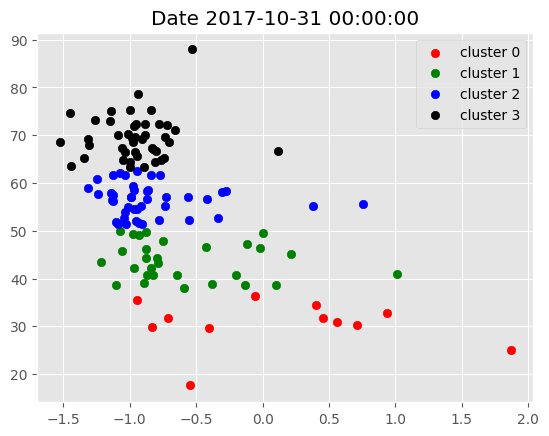

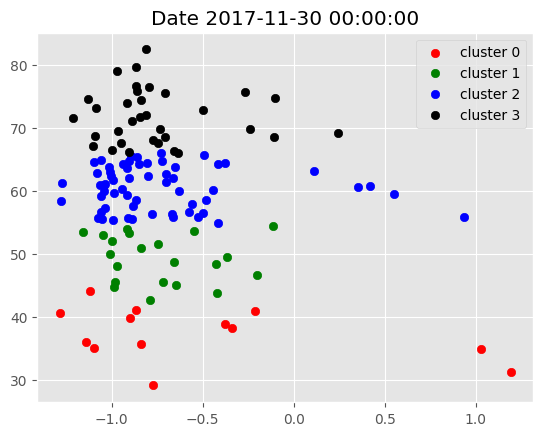

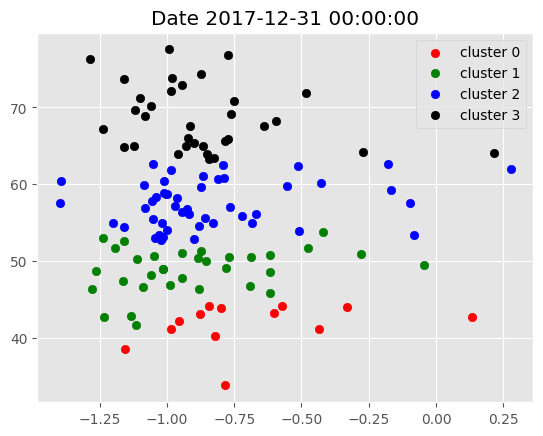

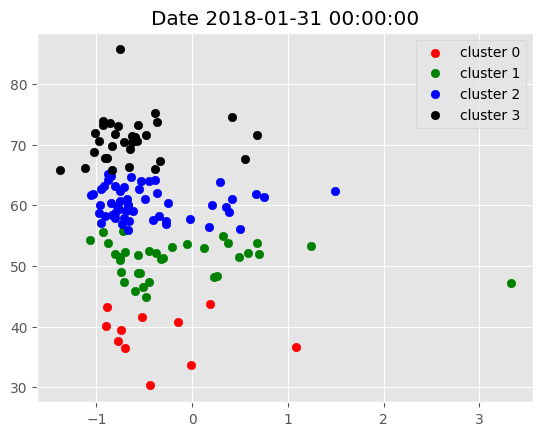

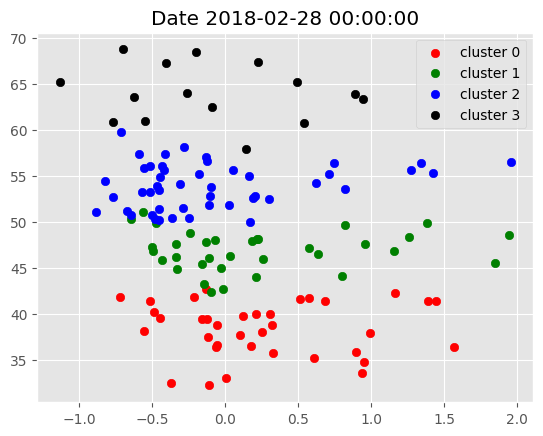

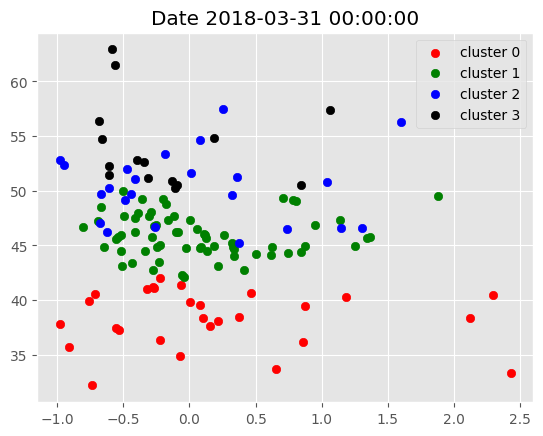

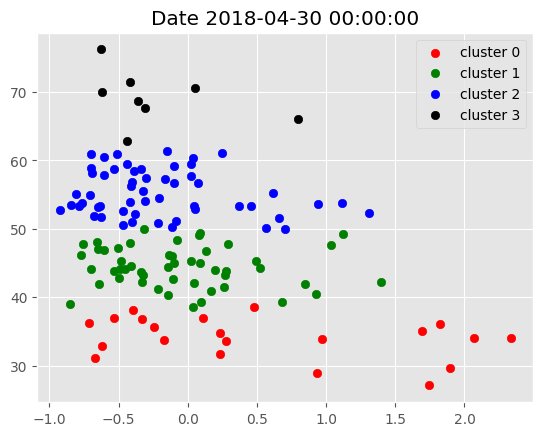

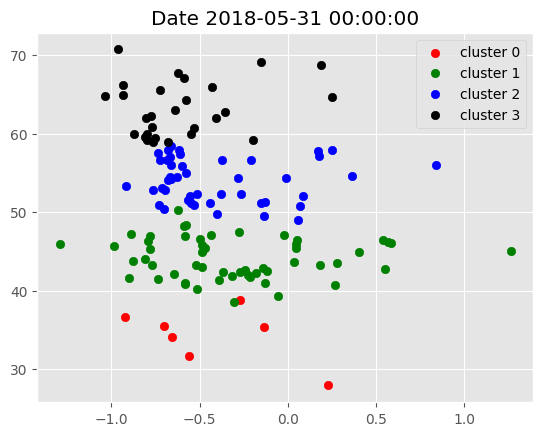

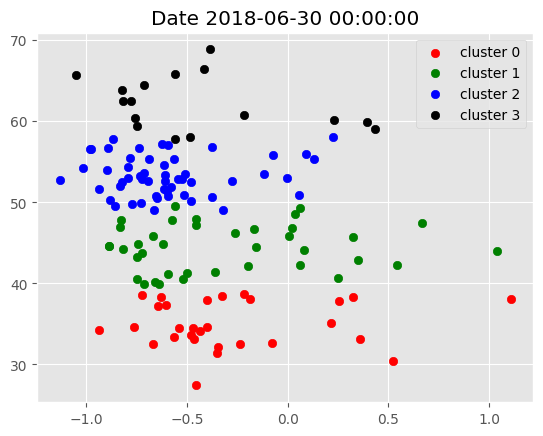

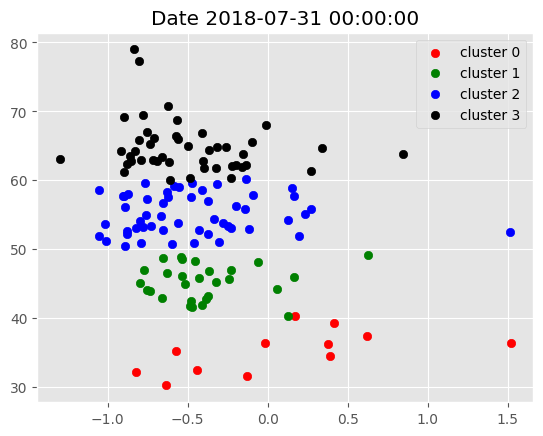

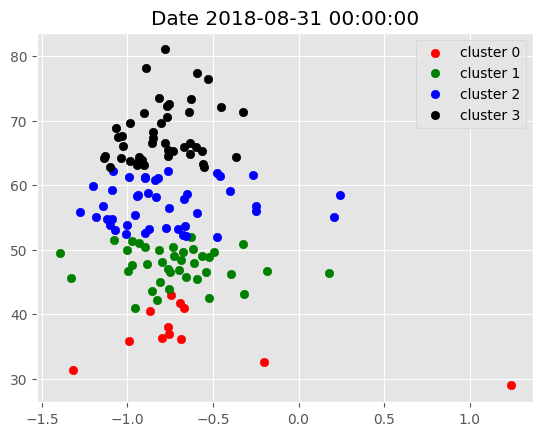

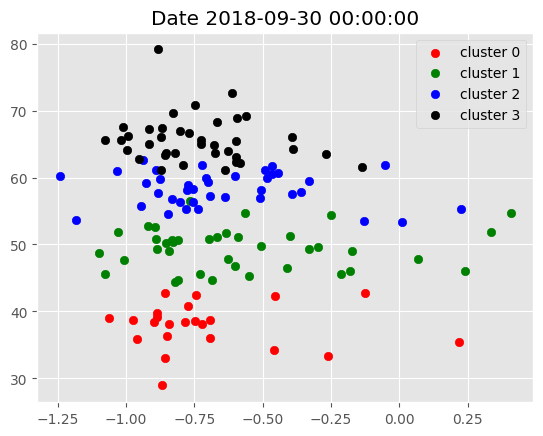

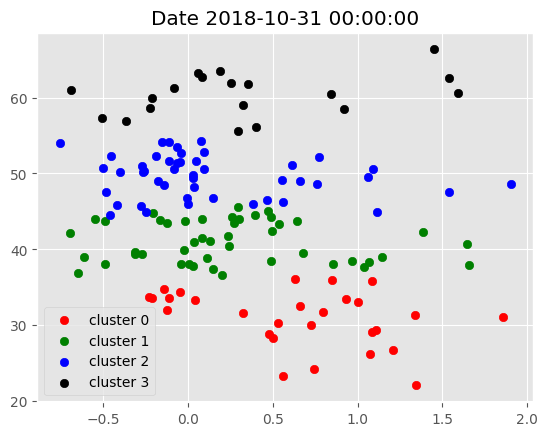

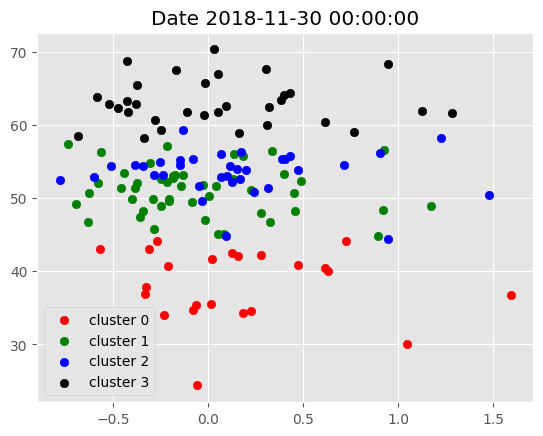

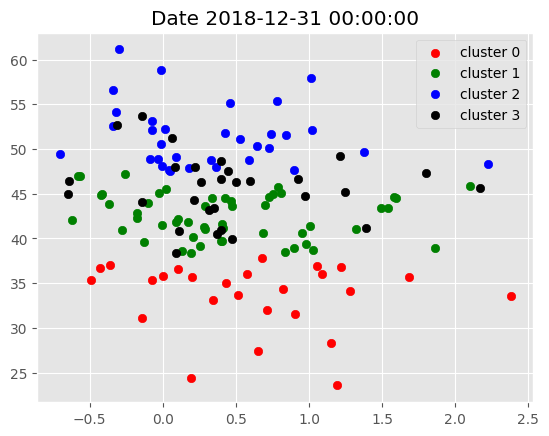

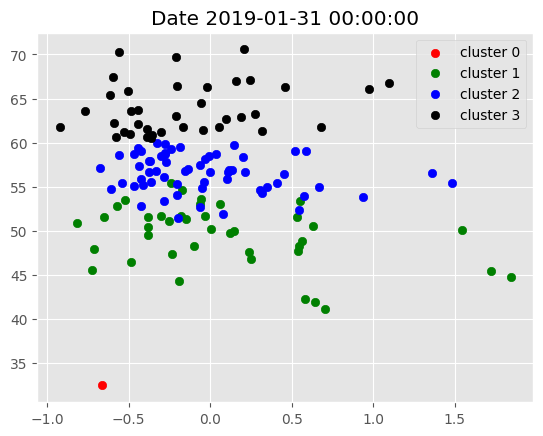

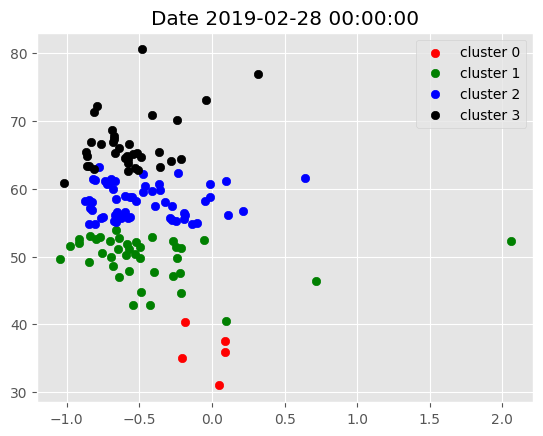

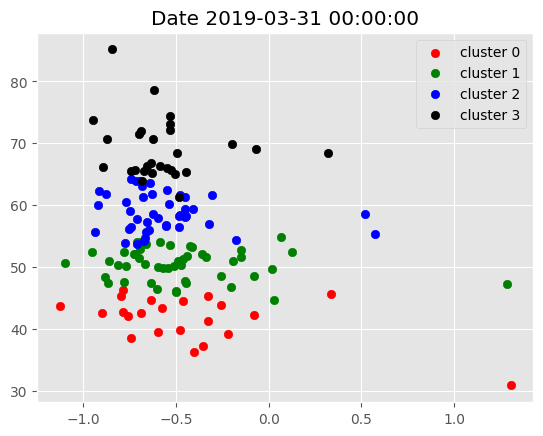

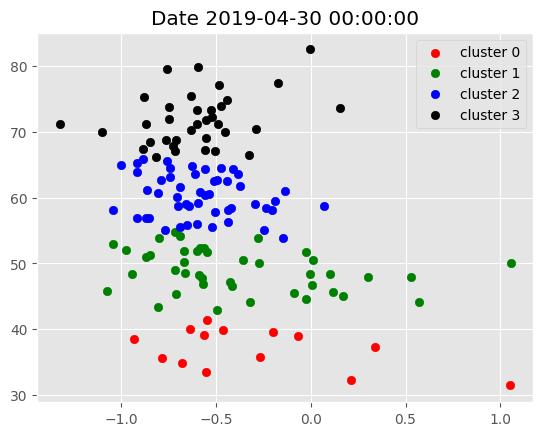

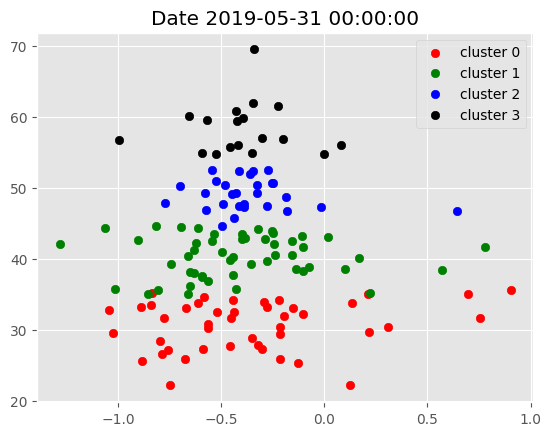

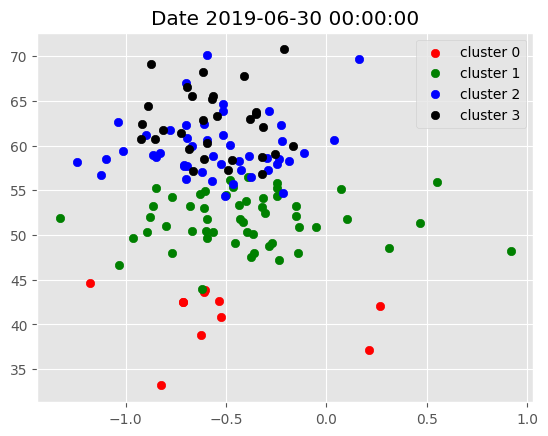

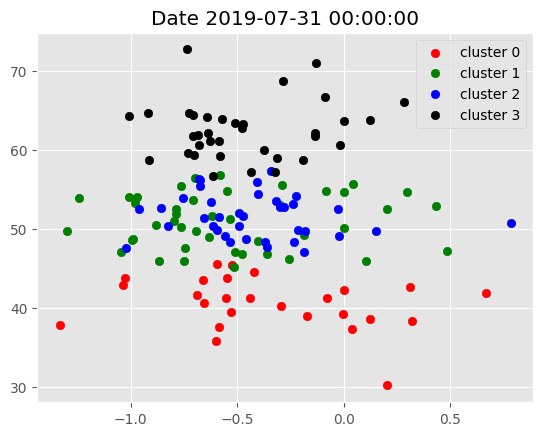

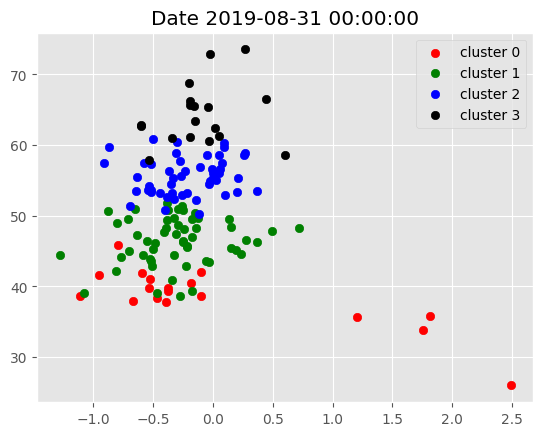

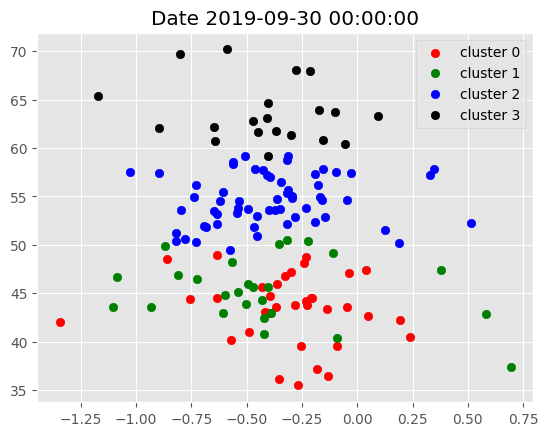

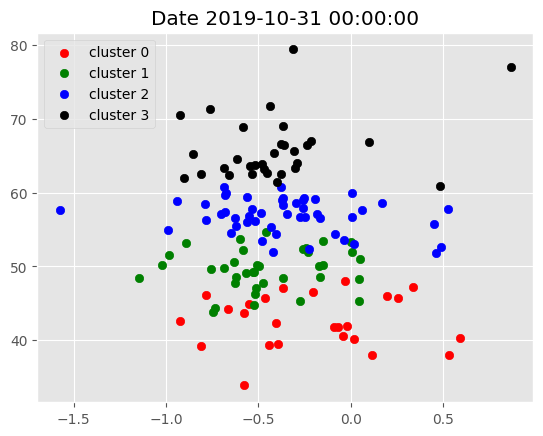

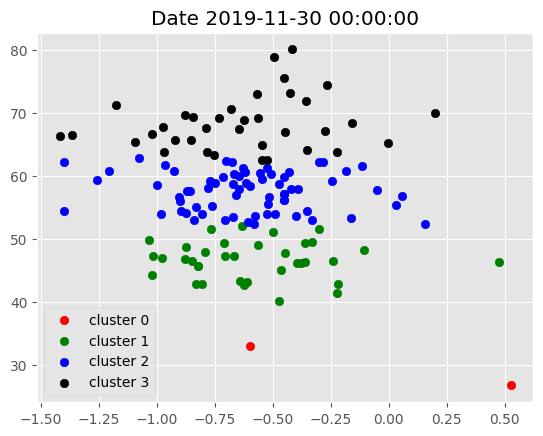

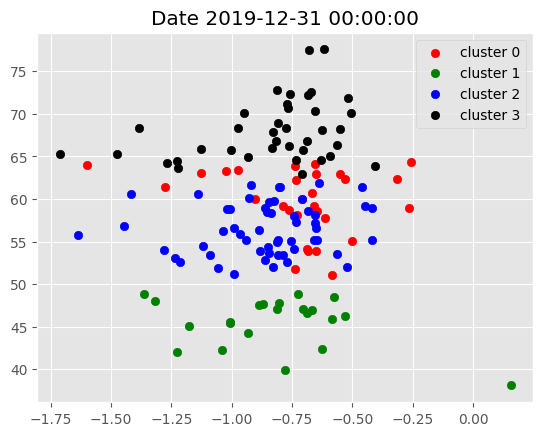

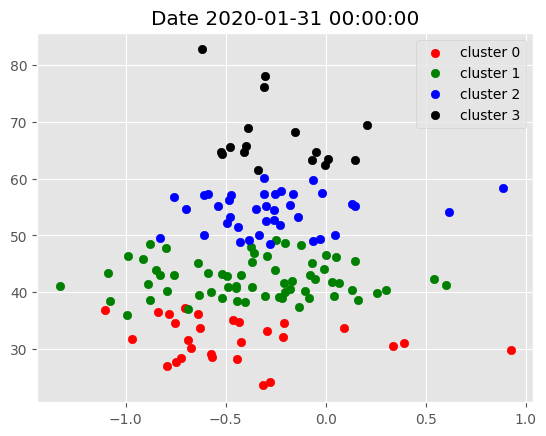

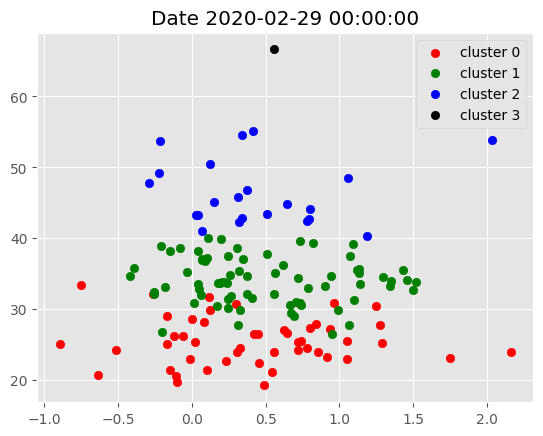

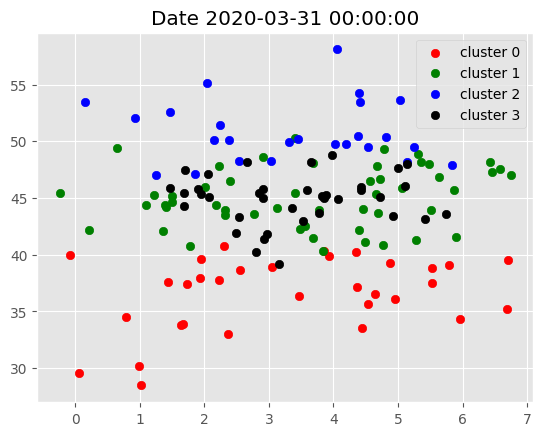

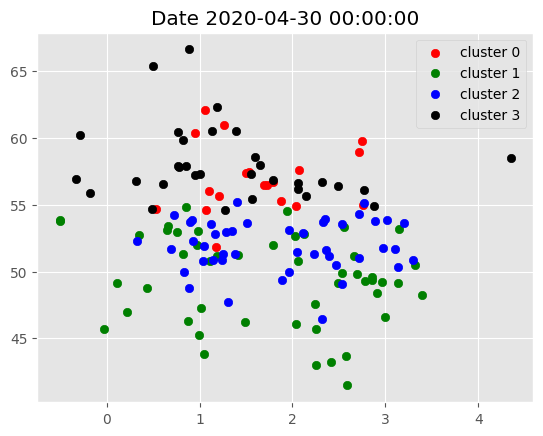

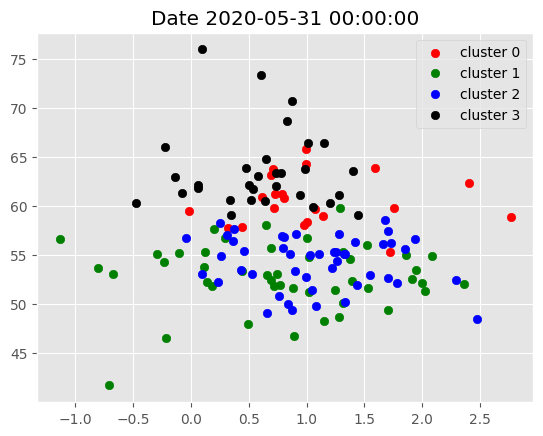

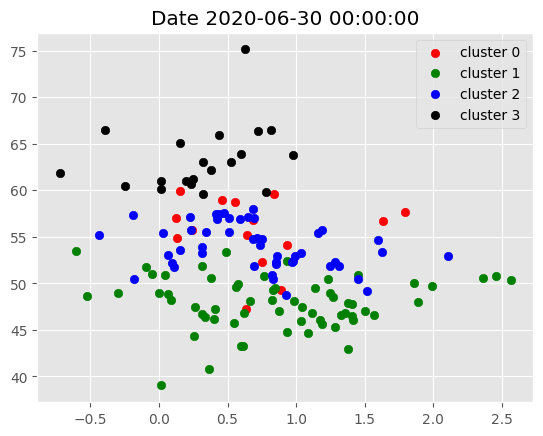

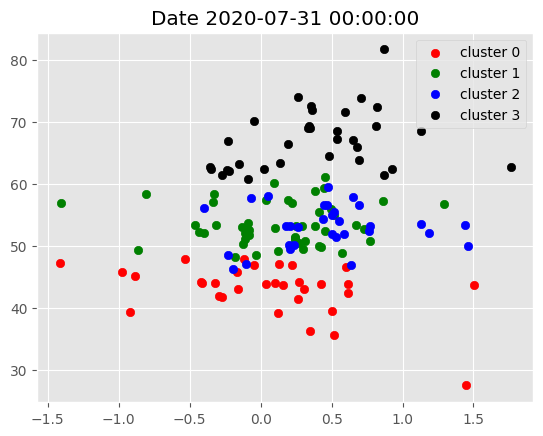

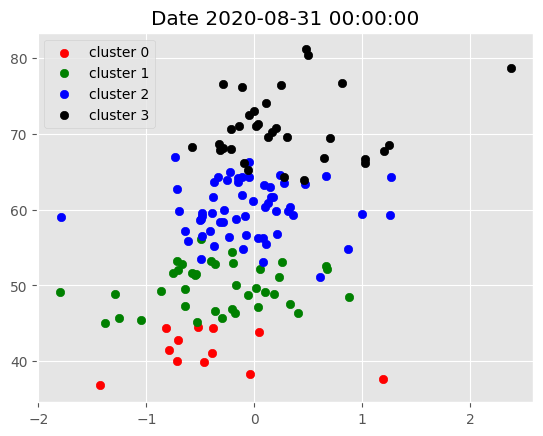

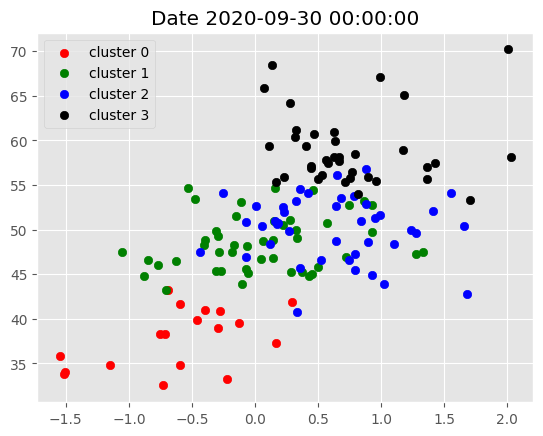

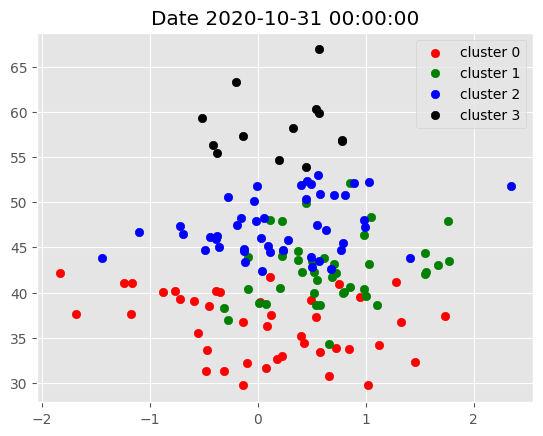

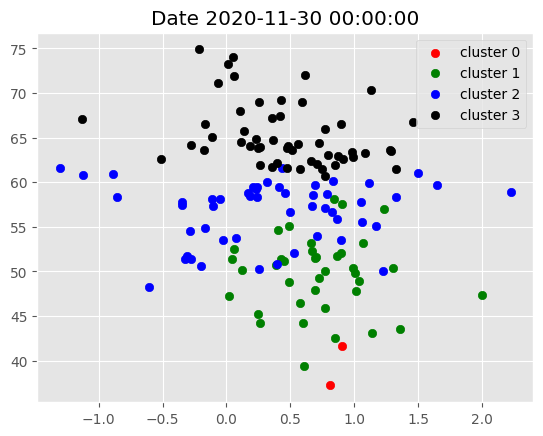

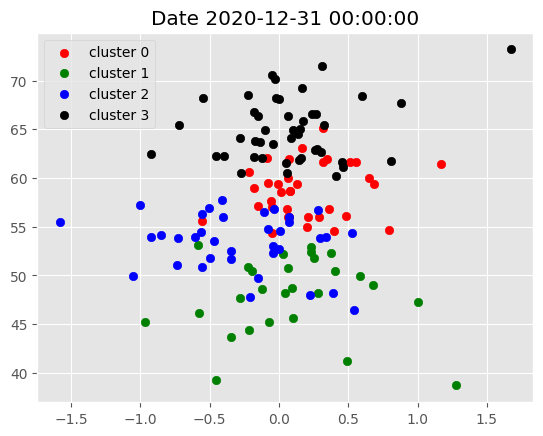

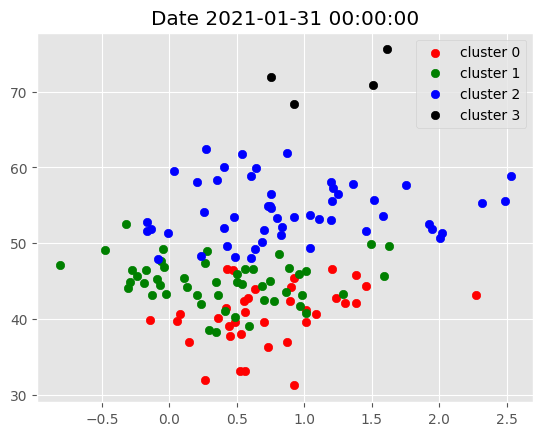

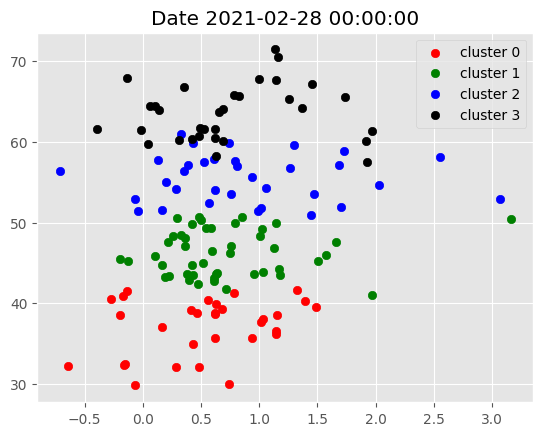

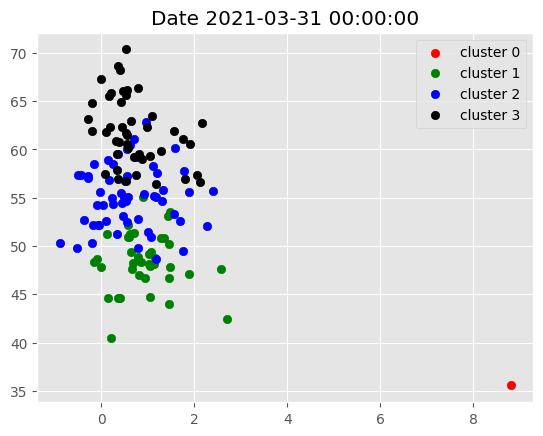

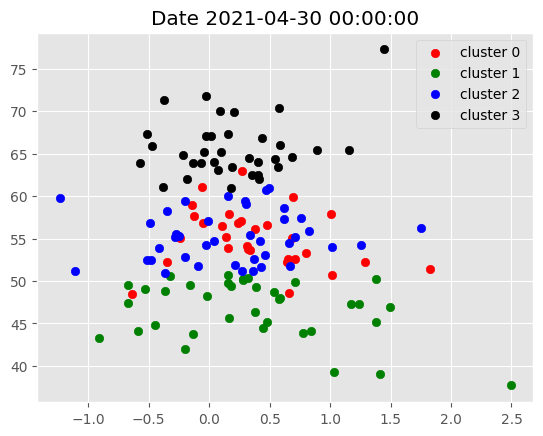

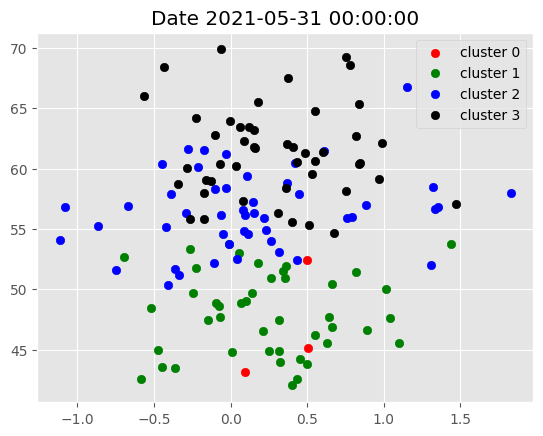

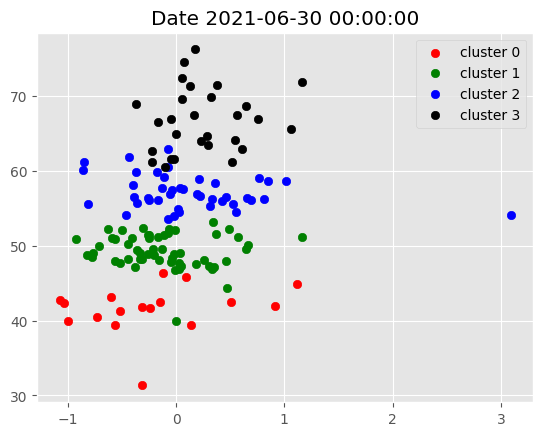

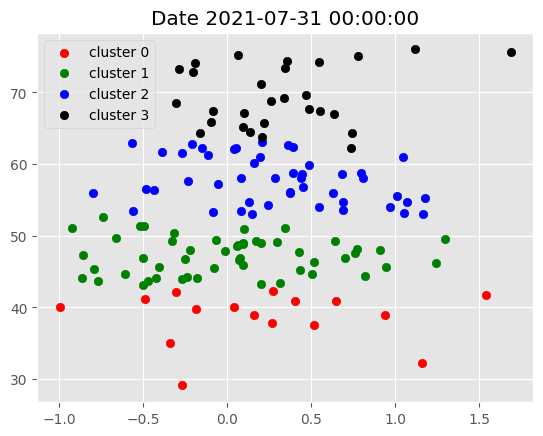

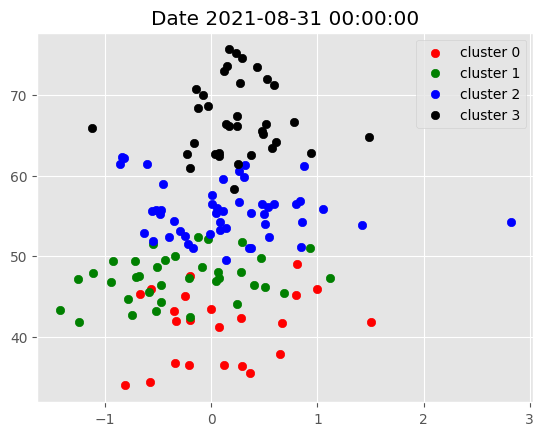

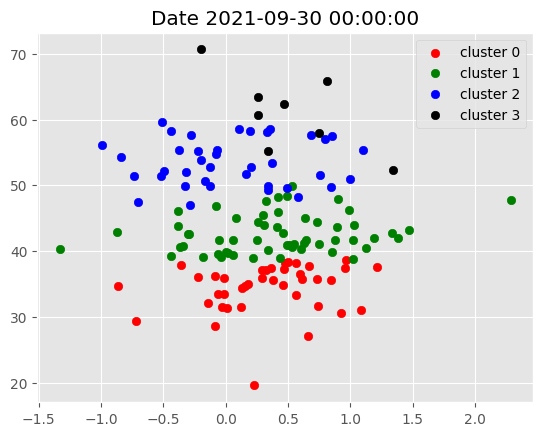

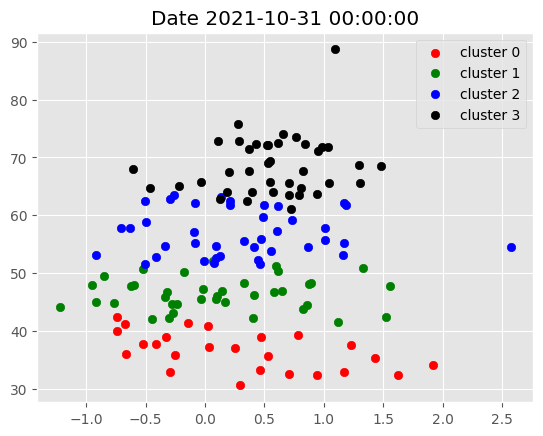

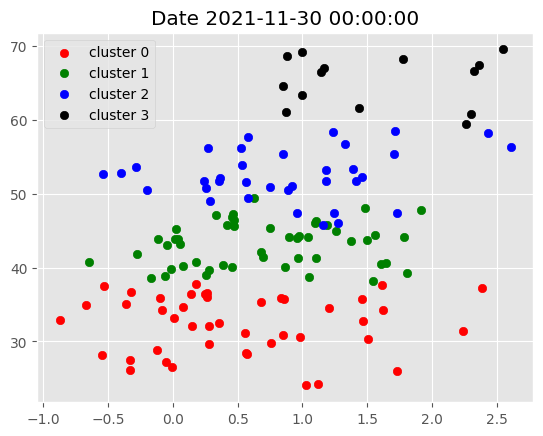

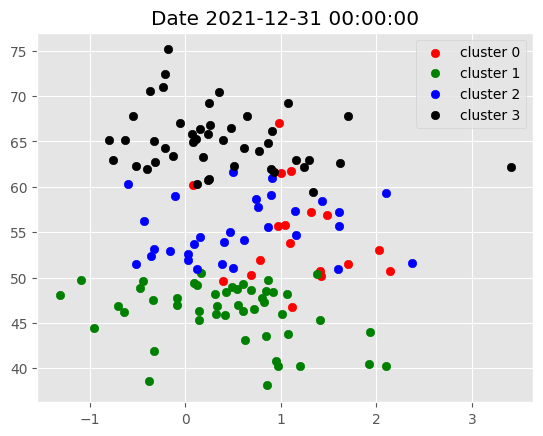

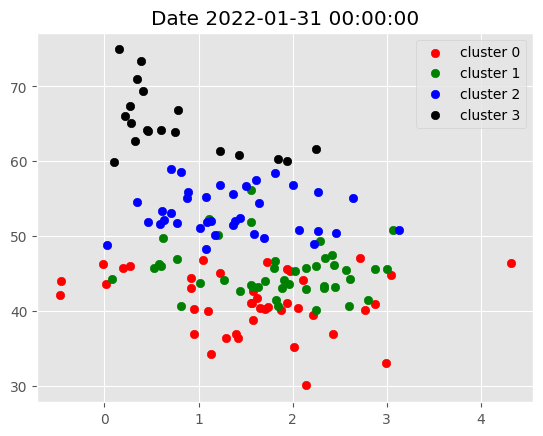

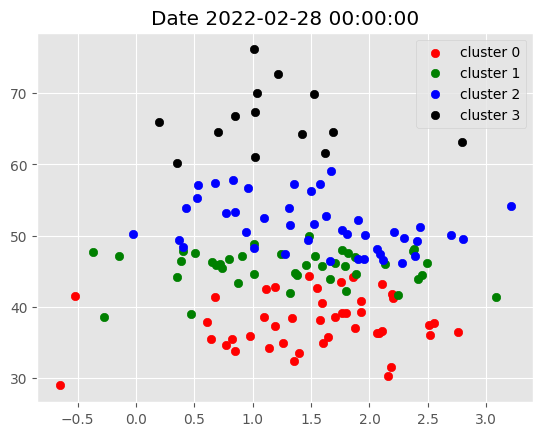

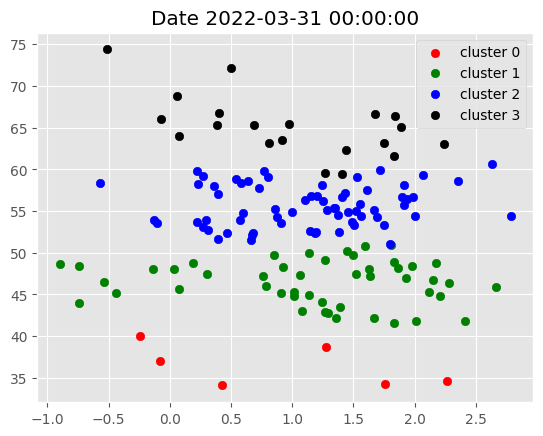

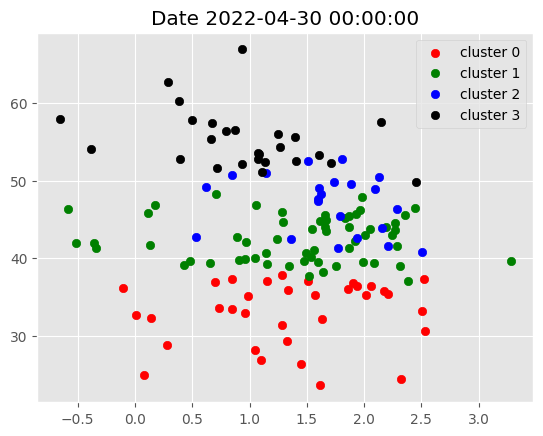

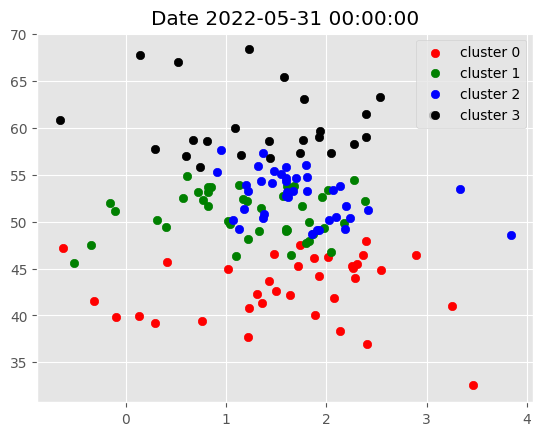

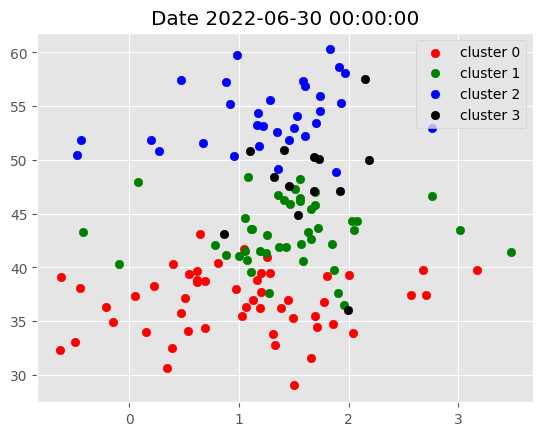

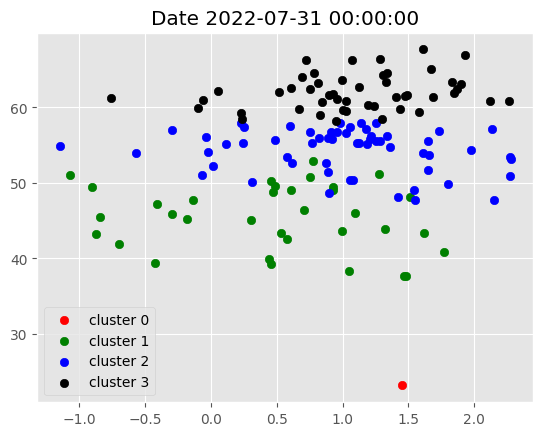

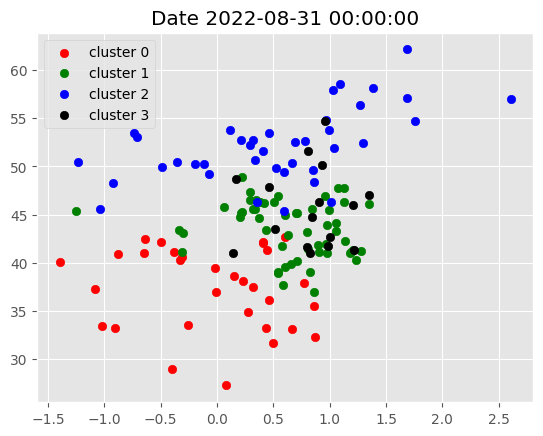

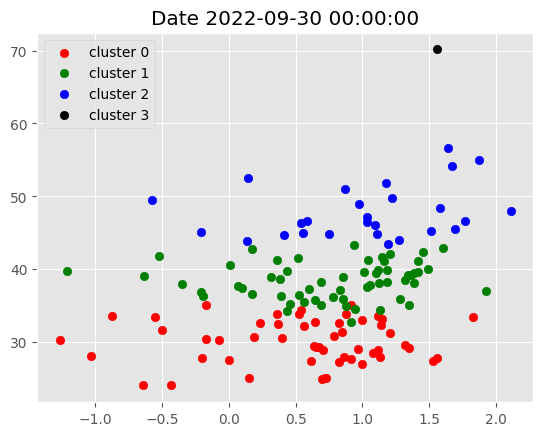

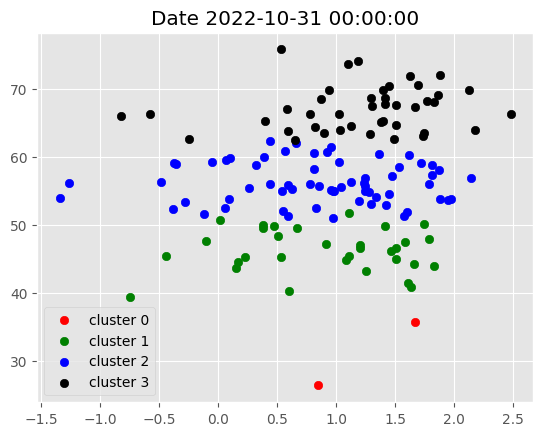

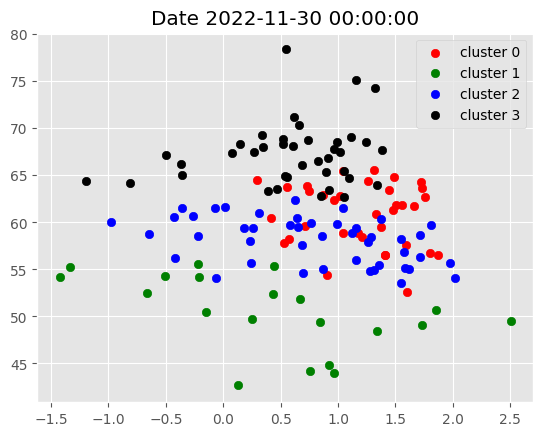

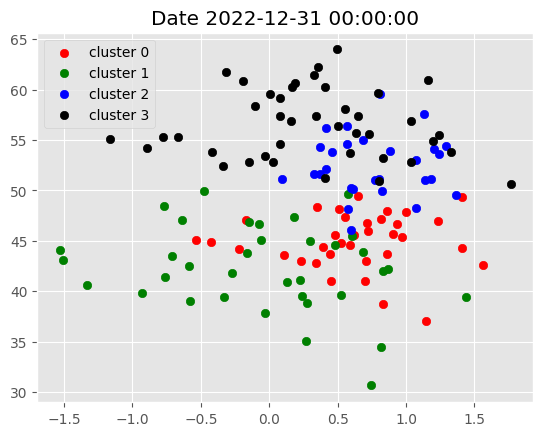

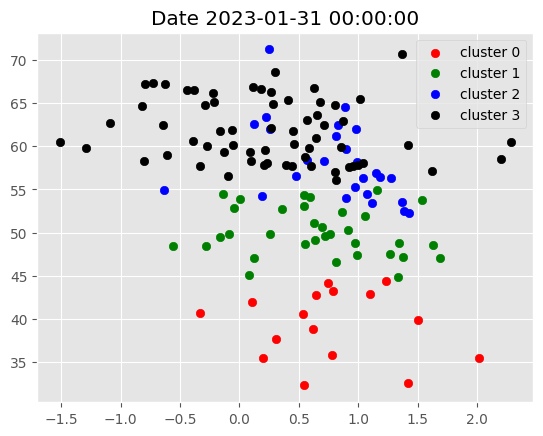

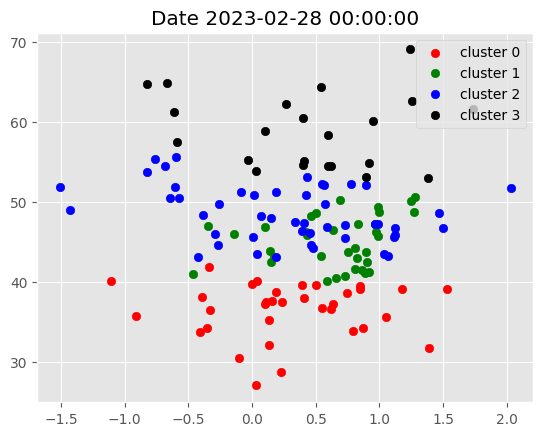

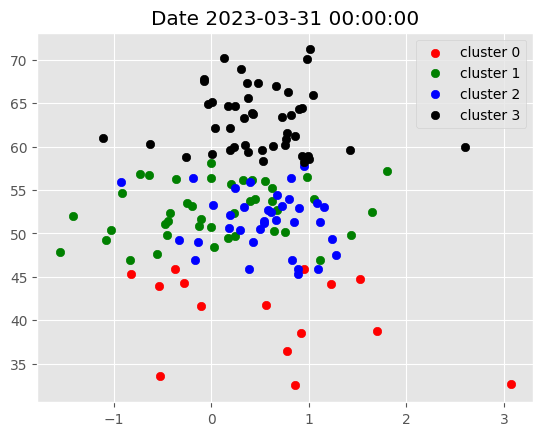

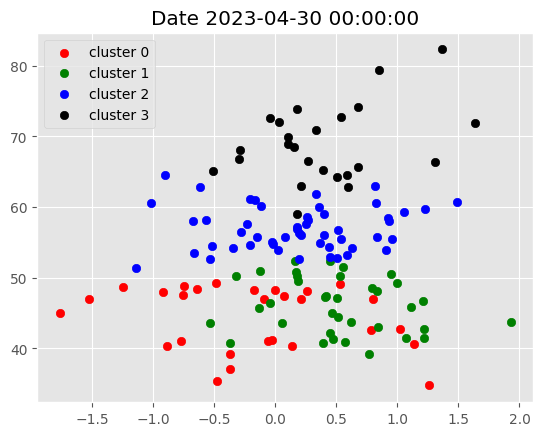

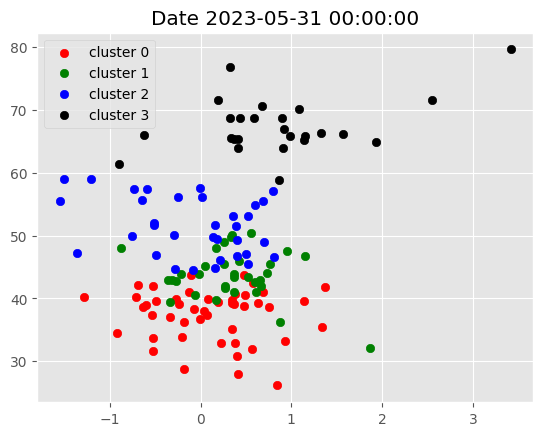

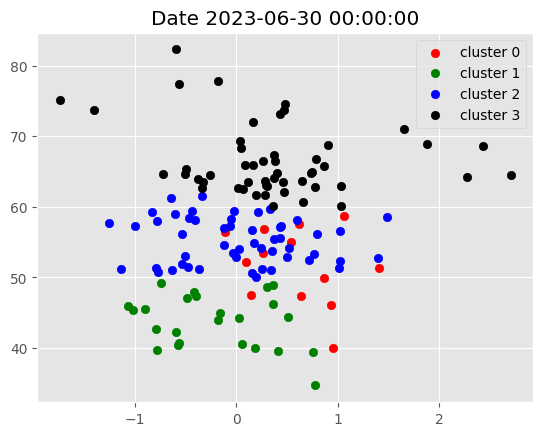

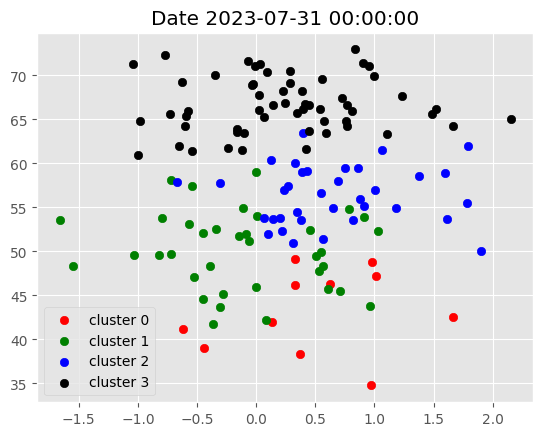

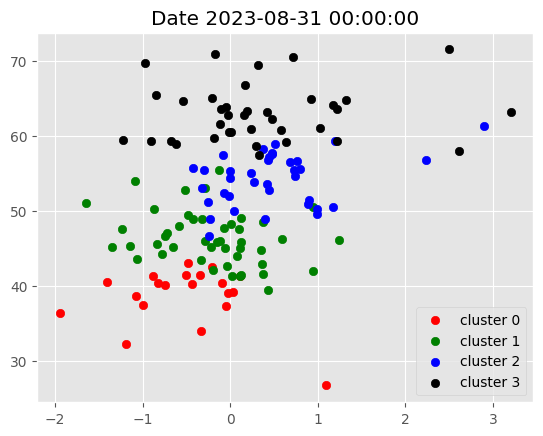

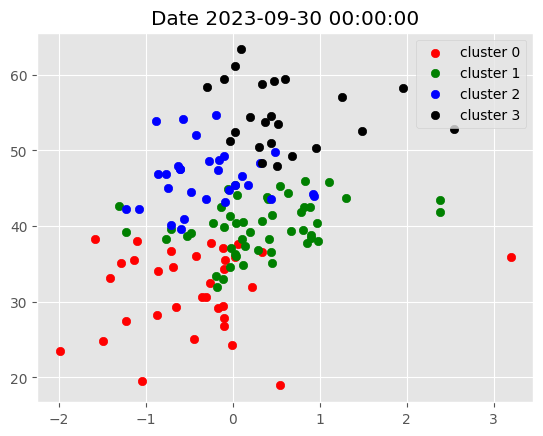

In [ ]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

  g = data.xs(i, level=0)

  plt.title(f'Date {i}')

  plot_clusters(g)



**Apply pre-defined centroids**

In [ ]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

#7. For each month select assets based on cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
- First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

- Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.

In [47]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index + pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
  fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2017-11-01': ['AAPL',
  'ACN',
  'ADBE',
  'AMAT',
  'AMZN',
  'AVGO',
  'AXP',
  'BAC',
  'CAT',
  'COP',
  'CRM',
  'CTSH',
  'DE',
  'DHR',
  'DLTR',
  'ELV',
  'EOG',
  'GOOG',
  'GOOGL',
  'INTC',
  'ISRG',
  'JPM',
  'MA',
  'MAR',
  'MCD',
  'MET',
  'META',
  'MMM',
  'MSFT',
  'MU',
  'NEE',
  'NVDA',
  'NXPI',
  'ORCL',
  'PYPL',
  'SHW',
  'STZ',
  'TXN',
  'UNH',
  'V',
  'VLO',
  'WMT',
  'XOM'],
 '2017-12-01': ['ACN',
  'AMZN',
  'AXP',
  'AZO',
  'BA',
  'BAC',
  'BRK-B',
  'CAT',
  'COST',
  'CSCO',
  'DE',
  'DLTR',
  'ELV',
  'HD',
  'HON',
  'ILMN',
  'ISRG',
  'JPM',
  'KR',
  'LUV',
  'MAR',
  'MCD',
  'MMM',
  'NKE',
  'ORLY',
  'OXY',
  'QCOM',
  'SCHW',
  'UNH',
  'UNP',
  'VLO',
  'VZ',
  'WMT'],
 '2018-01-01': ['ACN',
  'AZO',
  'BA',
  'BAC',
  'CAT',
  'CSCO',
  'CVX',
  'DAL',
  'DE',
  'DG',
  'EOG',
  'FCX',
  'FDX',
  'HAL',
  'HD',
  'KR',
  'LOW',
  'LUV',
  'MAR',
  'OXY',
  'PEP',
  'PXD',
  'RTX',
  'SCHW',
  'STZ',
  'T',
  'TXN',
  'UAL',
  'UNP

# Define portfolio optimization function

- We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

- To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

- Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [57]:
!pip install -q PyPortfolioOpt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.1 MB/s eta 0:00:00


In [60]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):

  returns = expected_returns.mean_historical_return(prices=prices,
                                                    frequency=252)
  cov = risk_models.sample_cov(prices=prices,
                               frequency=252)

  ef = EfficientFrontier(expected_returns=returns,
                         cov_matrix=cov,
                         weight_bounds=(lower_bound, .1),
                         solver='SCS')
  weights = ef.max_sharpe()

  return ef.clean_weights()

In [61]:
data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2017-10-31 AAL     1.011062  3.994389  3.849110  3.921750          7.138676   
           AAPL   -0.906642  3.689797  3.596048  3.642922          6.680366   
           ABBV    0.375557  4.298592  4.205859  4.252226          9.976159   
           ABT    -1.040044  3.944558  3.897414  3.920986          7.693001   
           ACN    -0.986514  4.885869  4.806508  4.846188         12.149380   
...                     ...       ...       ...       ...               ...   
2023-09-30 WFC    -0.558742  3.783384  3.702645  3.743015          6.578654   
           WMT    -0.196381  4.026648  3.991704  4.009176          7.692654   
           XOM     0.601335  4.775304  4.695106  4.735205         11.131335   
           MRNA   -0.529511  4.788149  4.582514  4.685332         10.370675   
           UBER   -0.746098  3.917801  3.806654  3.862227          6.949701   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2017-10-31 AAL    -0.018697  41.051780  -0.014108   0.022981  -0.023860   
           AAPL   -0.039275  69.196661   0.096808   0.015250   0.044955   
           ABBV    0.473814  55.247906   0.022728   0.098590   0.091379   
           ABT     0.276132  53.844865   0.021275   0.034308   0.034801   
           ACN     0.352340  69.365158   0.064180   0.048454   0.037202   
...                     ...        ...        ...        ...        ...   
2023-09-30 WFC    -0.282325  40.920288  -0.015500  -0.057917  -0.013554   
           WMT     0.399458  54.722509  -0.000677   0.010014   0.012354   
           XOM     1.400623  59.440179   0.046947   0.046139   0.030496   
           MRNA   -0.376899  38.747314  -0.132219  -0.086803  -0.068763   
           UBER   -0.133973  45.005268  -0.062672  -0.053920   0.008422   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAL      0.016495   0.007008    0.012702  1.265664  1.314317   
           AAPL     0.028875   0.038941    0.035228  1.275750 -0.271696   
           ABBV     0.056495   0.047273    0.044026  0.494522  0.362281   
           ABT      0.038672   0.031320    0.029294  0.828092 -0.199021   
           ACN      0.028692   0.027398    0.018728  1.199048 -0.166702   
...                      ...        ...         ...       ...       ...   
2023-09-30 WFC      0.016712   0.000703    0.003255  1.137639  0.314482   
           WMT      0.017574   0.016553    0.020256  0.740055 -0.261890   
           XOM      0.012838   0.008747    0.027037  1.005967 -1.051369   
           MRNA    -0.071952  -0.064976   -0.015431  1.155154  0.762525   
           UBER     0.057244   0.066838    0.043691  1.078922  1.162540   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-10-31 AAL     0.601340  0.458860  0.563293        1  
           AAPL   -0.591145  0.647780  0.458080        3  
           ABBV   -0.033101  0.241982  0.164921        2  
           ABT    -0.529383  0.252405  0.970211        2  
           ACN    -0.328213  0.267789  0.168883        3  
...                     ...       ...       ...      ...  
2023-09-30 WFC     2.009074 -0.404338 -1.468840        2  
           WMT    -0.522677 -0.126426  0.642626        2  
           XOM     1.707834 -0.675677 -0.284025        3  
           MRNA   -1.165677  0.590306  0.993548        1  
           UBER   -0.257003 -1.482231 -0.450323        2  

[10086 rows x 19 columns]

In [63]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0] - pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])
new_df


[*********************100%%**********************]  155 of 155 completed


Price       Adj Close                                                 \
Ticker            AAL        AAPL        ABBV        ABT         ACN   
Date                                                                   
2016-10-31  39.134338   26.248026   40.620972  34.463531  103.970650   
2016-11-01  38.363209   25.774111   41.108891  34.296665  103.881210   
2016-11-02  38.276459   25.797228   41.356483  33.989265  106.090500   
2016-11-03  38.054207   25.520712   40.701084  33.708225  104.605705   
2016-11-04  38.402084   25.290668   40.810307  34.331791  104.856163   
...               ...         ...         ...        ...         ...   
2023-09-25  12.910000  175.624222  151.668289  96.467384  314.532135   
2023-09-26  12.700000  171.514893  150.942551  95.240143  308.201630   
2023-09-27  12.610000  169.988831  150.177597  94.547340  311.942413   
2023-09-28  12.920000  170.248184  149.314560  97.110695  298.437927   
2023-09-29  12.810000  170.766830  146.186050  95.853752  304.728760   

Price                                                                  ...  \
Ticker            ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2016-10-31  107.510002   74.257111   72.279999  50.735882   26.654831  ...   
2016-11-01  106.870003   74.137711   70.099998  49.897133   26.489847  ...   
2016-11-02  105.889999   76.747704   68.680000  49.790245   26.205698  ...   
2016-11-03  107.169998   76.193298   67.610001  47.816723   25.912382  ...   
2016-11-04  106.199997   75.980064   69.440002  47.183563   25.866550  ...   
...                ...         ...         ...        ...         ...  ...   
2023-09-25  511.600006  237.203598  205.669998  61.502777  136.066559  ...   
2023-09-26  506.299988  234.456207  201.660004  60.641556  133.566162  ...   
2023-09-27  502.600006  239.782959  202.279999  60.394081  134.542404  ...   
2023-09-28  504.670013  240.454971  207.889999  60.661354  137.690292  ...   
2023-09-29  509.899994  237.757019  206.910004  59.988220  137.919418  ...   

Price         Volume                                                           \
Ticker             V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                            
2016-10-31  10024000  4969500  1928200  12459400   4662100  3363200  20115900   
2016-11-01  10881500  7816800  2458200  13229400   5130800  3821100  20020200   
2016-11-02   9170900  7317600  2580400  16488200   9783100  4216200  19566600   
2016-11-03   7563100  3855900  2371000  12605100   4586500  3192600  14982700   
2016-11-04   7588100  3729900  1902100  14410200   7023900  2705600  27391600   
...              ...      ...      ...       ...       ...      ...       ...   
2023-09-25   5921600  3241900   698100  17616900   6891000  2685900  10624000   
2023-09-26   6193200  4936800   633600  18841600   7570500  3571100  15219400   
2023-09-27   6006700  3644000   860600  22083500  10182900  2547800  11815500   
2023-09-28   4203900  3587300   578900  18772100   7291500  3282000  12454600   
2023-09-29   6044200  4302200   896800  19759400  25659100  2512000  13119100   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2016-10-31  19167000  1341600  16663800  
2016-11-01  26515800  3722300  13050600  
2016-11-02  22935900  2542400  11226100  
2016-11-03  20411700  9050400   8836500  
2016-11-04  21786300  3223800  13877100  
...              ...      ...       ...  
2023-09-25  10459500  1387800  11316000  
2023-09-26  14435700  1454000  11805400  
2023-09-27  15711000  2050000  23976200  
2023-09-28  11617200  1290400  16808100  
2023-09-29  18842400  1326800  18810700  

[1740 rows x 930 columns]

In [64]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
  try:

    end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

    cols = fixed_dates[start_date]

    optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')

    optimization_end_date = (pd.to_datetime(end_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')

    optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

    success = False
    try:
        weights = optimize_weights(prices=optimization_df,
                                lower_bound=round(1/(len(optimization_df.columns)*2),3))

        weights = pd.DataFrame(weights, index=pd.Series(0))

        success = True
    except:
        print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')

    if success==False:
        weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                  index=optimization_df.columns.tolist(),
                                  columns=pd.Series(0)).T

    temp_df = returns_dataframe[start_date:end_date]

    temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                      left_index=True,
                      right_index=True)\
                .reset_index().set_index(['Date', 'index']).unstack().stack()

    temp_df.index.names = ['date', 'ticker']

    temp_df['weighted_return'] = temp_df['return']*temp_df['weight']
    temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

    portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

  except Exception as e:
    print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"


,Strategy Return
date,
2017-11-01,0.001685
2017-11-02,0.003610
2017-11-03,0.006586
2017-11-06,0.003195
2017-11-07,0.002145
...,...
2023-09-25,0.003849
2023-09-26,-0.011135
2023-09-27,0.006844


#8. Visualize Portfolio returns and compare to SP500 returns

In [65]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2017-11-01,0.001685,0.001321
2017-11-02,0.003610,0.000388
2017-11-03,0.006586,0.003333
2017-11-06,0.003195,0.001547
2017-11-07,0.002145,-0.000696
...,...,...
2023-09-25,0.003849,0.004196
2023-09-26,-0.011135,-0.014800
2023-09-27,0.006844,0.000399
2023-09-28,0.006292,0.005781


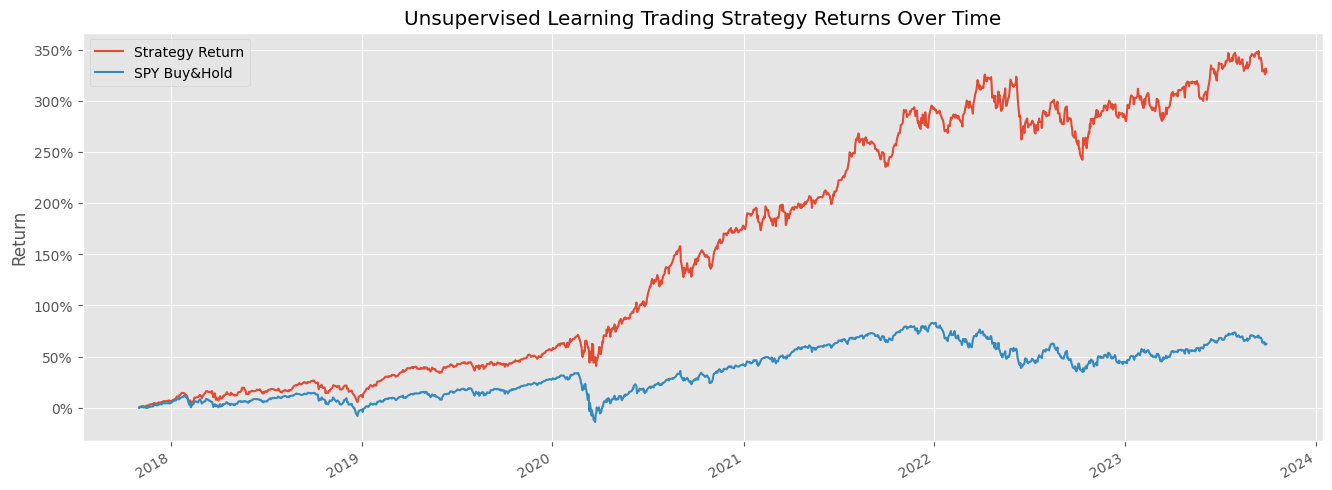

In [66]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()